### Setup dask for machine learning

In [ ]:
%matplotlib inline

In [ ]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt
import dask.array as da 
from dask_ml.datasets import make_classification
import pandas as pd

In [1]:
# Create random data
import dask
import dask.array as da
from dask_ml.datasets import make_classification


n, d = 3500, 162

X, y = make_classification(n_samples=n, n_features=d,
                           chunks=n // 10, flip_y=0.2)
X
X = X.persist()
X

dask.array<normal, shape=(3500, 162), dtype=float64, chunksize=(350, 162)>

In [2]:
# Split data
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train

dask.array<concatenate, shape=(3150, 162), dtype=float64, chunksize=(315, 162)>

In [54]:
# Compute the AUC, F1 and confusion matrix for your best model on the training data

from dask_ml.linear_model import LogisticRegression
from dask_ml.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Logistic regression
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_true = y_test
y_pred_lr = lr.predict(X_test)
accuracy_score(y_true, y_pred_lr)

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_lr)
print('AUC_lr: %.3f' % metrics.auc(fpr, tpr))
print('F1_lr: %.3f' % f1_score(y_true, y_pred_lr))




AUC_lr: 0.568
F1_lr: 0.582


[[ 99  73]
 [ 73 105]]


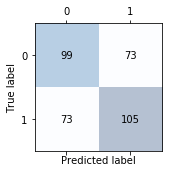

In [59]:
# Confusion matrix test
import matplotlib.pyplot as plt

confmat_test = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat_test)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_test, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_test.shape[0]):
    for j in range(confmat_test.shape[1]):
        ax.text(x=j, y=i, s=confmat_test[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

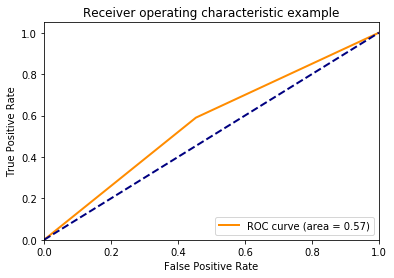

In [60]:
# Plot the ROC for your best model on the training data
# Compute ROC curve and ROC area for each class

roc_auc=metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# What are the dimensions of your training and test data? 
print(X_train.shape)
print(X_test.shape)



### Why do we use F1 (Dice) as the scoring metric in Kaggle and not accuracy? 

#### Answer: F1 Score is needed when you want to seek a balance between Precision and Recall.  F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives) (https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9). In our case, we have an uneven class distribution since most of the classes in the target at acutal negatives (0) or healthy vs. cancer (1)


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Define the pipeline (with scaling and classification method):
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

# Define ranges of parameter values:
C_range  = [0.1, 1.0, 10.0, 100.0, 1000.0,10000] # For regularization parameter C (margin).
G_range2 = [0.00001,0.0001, 0.001, 0.01, 0.1] # For scaling parameter gamma (in rbf-kernel - radius).

# Define the grid structure:
param_grid   = [{'svc__C': C_range, 'svc__kernel': ['linear']},
                {'svc__C': C_range, 'svc__gamma': G_range2, 'svc__kernel': ['rbf']}]

# Define grid seach on the hyperparameters (C, gamma & choice of kernel) 
# provided by the pipline, grid structure and specified CV strategy:
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
print(gs)

In [ ]:
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

In [ ]:
clf = gs.best_estimator_
print(clf)
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

In [ ]:
# Confusion matrix for test and train

from sklearn.metrics import confusion_matrix

#pipe_svc.fit(X_train, y_train)
#y_pred  = pipe_svc.predict(X_test)  # Predictins of test data 
#y_fit   = pipe_svc.predict(X_train) # Predictins (fitted values) of training data

clf     = pipe_svc.fit(X_train, y_train)
print('Train accuracy: %.3f' % clf.score(X_train, y_train))
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

y_pred  = clf.predict(X_test)  # Predictions of test data 
y_fit   = clf.predict(X_train) # Predictions (fitted values) of training data

confmat_test = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat_test)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_test, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_test.shape[0]):
    for j in range(confmat_test.shape[1]):
        ax.text(x=j, y=i, s=confmat_test[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()


confmat_train = confusion_matrix(y_true=y_train, y_pred=y_fit)
print(confmat_train)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_train, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_train.shape[0]):
    for j in range(confmat_train.shape[1]):
        ax.text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)
